In [1]:
import pandas as pd
import numpy as np

import operator 

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Load file with all PMD customers 

In [2]:
data = pd.read_csv("../PMD_Analysis/data/pmd_full_4.txt",sep = "\t", header=None)

In [3]:
data.columns = ['encrypted_customer_id','is_promo','is_pmd','revenue','units','min_date','max_date']


data['min_date'] = pd.to_datetime(data['min_date'])
data['max_date'] = pd.to_datetime(data['max_date'])

In [4]:
data.shape

(4873194, 7)

In [5]:
print(data.shape)
print(data['encrypted_customer_id'].nunique())
data.head()

(4873194, 7)
2113141


,encrypted_customer_id,is_promo,is_pmd,revenue,units,min_date,max_date
0,A29NFF34BNM6WI,non_promo,non_pmd,49.01,11,2016-12-23,2019-05-20
1,A2XOOG7N9LBM2D,non_promo,non_pmd,289.94,72,2015-08-18,2019-07-06
2,A37HBT237VVUN7,non_promo,non_pmd,3358.30,343,2014-12-06,2019-05-30
3,APLRQYYT84YUL,promo,non_pmd,8.31,2,2018-11-26,2019-02-24
4,A1R8G0LEHUYM9,non_promo,non_pmd,1926.09,474,2015-03-14,2019-07-06


# Part One - how many customers have only pmd

In [6]:
table = pd.pivot_table(data, values='units', index=['encrypted_customer_id'],
                       columns=['is_pmd'], aggfunc=np.sum, fill_value=0).reset_index()

In [7]:
table.head()

is_pmd,encrypted_customer_id,is_pmd,non_pmd
0,A0000366A0GK5998YBDT,1,71
1,A0000666DG4NFCAMI8,5,30
2,A0001210LXBR1BZ5BP3,13,19
3,A00014502OC4OBEX6TX4A,1,1
4,A0002142161IPUDSA8D6H,4,27


In [8]:
table[table['non_pmd'] == 0].shape[0] / table['encrypted_customer_id'].nunique()

0.037025451685429416

In [9]:
table[table['non_pmd'] == 0].tail()

is_pmd,encrypted_customer_id,is_pmd,non_pmd
2113077,AZZV50VYBWJ11,5,0
2113104,AZZX1XYC5954A,1,0
2113124,AZZYC5ZA1SQUR,3,0
2113127,AZZYO1YQ1HWI5,1,0
2113136,AZZZRNKD8SDUD,2,0


In [10]:
data[data['encrypted_customer_id'] == 'A0000666DG4NFCAMI8']

,encrypted_customer_id,is_promo,is_pmd,revenue,units,min_date,max_date
86995,A0000666DG4NFCAMI8,non_promo,non_pmd,110.65,27,2016-01-24,2019-06-01
2634146,A0000666DG4NFCAMI8,promo,is_pmd,15.91,5,2017-05-26,2018-11-23
3714286,A0000666DG4NFCAMI8,promo,non_pmd,12.57,3,2018-12-18,2018-12-23


# Part Two - sampled 

In [11]:
df = pd.read_csv("../PMD_Analysis/data/sampled_3.txt", sep = "\t", header=None)

In [12]:
df.columns = ['encrypted_customer_id','is_promo','is_pmd','fufill_date_local',
              'revenue','units','min_date','max_date']

print(df.shape)
df.head()

(2836684, 8)


,encrypted_customer_id,is_promo,is_pmd,fufill_date_local,revenue,units,min_date,max_date
0,A2RLB6IAOVHSC,promo,non_pmd,2018-05-11 00:00:00,5.82,1,2018-05-11 00:00:00,2018-05-11 00:00:00
1,AH1QVUJXV29YV,non_promo,non_pmd,2019-02-09 00:00:00,3.74,1,2019-02-09 00:00:00,2019-02-09 00:00:00
2,A1E4UD2ON5HELH,promo,is_pmd,2019-03-02 00:00:00,1.66,1,2019-03-02 00:00:00,2019-03-02 00:00:00
3,AT2LIPYSGZAVB,promo,non_pmd,2019-01-22 00:00:00,27.42,9,2019-01-22 00:00:00,2019-01-22 00:00:00
4,A19OO73NAGJSV,promo,non_pmd,2017-04-13 00:00:00,4.13,1,2017-04-13 00:00:00,2017-04-13 00:00:00


In [13]:
df[(df['is_promo'] == 'promo') & (df['is_pmd'] == 'is_pmd')]['fufill_date_local'].min()

'2017-07-07 00:00:00'

In [14]:
def first_pmd_event(df):
    
    """Create function to add first PMD column per customer """ 
    
    df['fufill_date_local'] = pd.to_datetime(df['fufill_date_local'])
    df['min_date'] = pd.to_datetime(df['min_date'])
    df['max_date'] = pd.to_datetime(df['max_date'])
    
    first_pmd = df[df['is_pmd'] == 'is_pmd'].groupby("encrypted_customer_id")['fufill_date_local'].min().reset_index()
    
    df_new = pd.merge(left = df, right = first_pmd, left_on = ['encrypted_customer_id'],
                     right_on = ['encrypted_customer_id'], how = 'left')
    
    df_new.columns = ['encrypted_customer_id','is_promo','is_pmd','fufill_date_local',
              'revenue','units','min_date','max_date','first_pmd_date']
    
    first_ever = df.groupby('encrypted_customer_id')['fufill_date_local'].min().reset_index()
    first_ever.columns = ['encrypted_customer_id','first_ever_purchase_date']
    
    df_new = pd.merge(left = df_new, right = first_ever, left_on = ['encrypted_customer_id'],
                     right_on = ['encrypted_customer_id'], how = 'left')
    
    
    return df_new

In [15]:
df_new = first_pmd_event(df)

In [16]:
print(df_new['first_pmd_date'].min())
df_new.head()

2017-07-07 00:00:00


,encrypted_customer_id,is_promo,is_pmd,fufill_date_local,revenue,units,min_date,max_date,first_pmd_date,first_ever_purchase_date
0,A2RLB6IAOVHSC,promo,non_pmd,2018-05-11,5.82,1,2018-05-11,2018-05-11,2018-07-06,2016-02-27
1,AH1QVUJXV29YV,non_promo,non_pmd,2019-02-09,3.74,1,2019-02-09,2019-02-09,2017-08-08,2015-05-16
2,A1E4UD2ON5HELH,promo,is_pmd,2019-03-02,1.66,1,2019-03-02,2019-03-02,2019-02-22,2018-08-19
3,AT2LIPYSGZAVB,promo,non_pmd,2019-01-22,27.42,9,2019-01-22,2019-01-22,2018-01-16,2015-07-14
4,A19OO73NAGJSV,promo,non_pmd,2017-04-13,4.13,1,2017-04-13,2017-04-13,2017-09-02,2014-06-03


In [17]:
table_pivot = pd.pivot_table(df_new, values='units', index=['encrypted_customer_id'],
                       columns=['is_pmd'], aggfunc=np.sum, fill_value=0).reset_index()

In [18]:
print("What proportion of PMD customers exclusively buy only PMD: ")
table_pivot[table_pivot['non_pmd'] == 0].shape[0] /  df_new['encrypted_customer_id'].nunique()

What proportion of PMD customers exclusively buy only PMD: 


0.06742

# Part Three - customers who purchased both

## Distribute frequency and units before and after first PMD

In [19]:
def split_initial_dataframe(df, comparator ):
    
    """function uses operator library to slice dataframe by dates relative to a reference timestamp.
    It allows to split the dataframe into 2 cohorts and see 
    """
    
    metrics_by_Promo =        df[comparator].groupby(["encrypted_customer_id",'is_promo','is_pmd'])['units','revenue'].sum().reset_index()
    first_purchase_by_Promo = df[comparator].groupby(["encrypted_customer_id",'is_promo','is_pmd'])['fufill_date_local'].min().reset_index()
    first_ever_purchase =     df[comparator].groupby(["encrypted_customer_id"])['fufill_date_local'].min().reset_index()
    last_purchase =           df[comparator].groupby(["encrypted_customer_id"])['fufill_date_local'].max().reset_index()
    last_purchase_by_Promo =  df[comparator].groupby(["encrypted_customer_id",'is_promo','is_pmd'])['fufill_date_local'].max().reset_index()
    
    df1 = pd.merge(left = metrics_by_Promo, right = first_purchase_by_Promo,
                   left_on = ["encrypted_customer_id",'is_promo','is_pmd'],
                   right_on = ["encrypted_customer_id",'is_promo','is_pmd'], how= 'left')
    
    df2 = pd.merge(left = df1, right = last_purchase_by_Promo,
                   left_on = ["encrypted_customer_id",'is_promo','is_pmd'],
                   right_on = ["encrypted_customer_id",'is_promo','is_pmd'], how= 'left')
    
    df3 = pd.merge(left=df2, right = first_ever_purchase,
                   left_on=["encrypted_customer_id"],
                   right_on = ["encrypted_customer_id"], how= 'left')
    
    df4 = pd.merge(left = df3, right = last_purchase,
                   left_on=["encrypted_customer_id"],
                   right_on = ["encrypted_customer_id"], how= 'left')
    
    df4.columns = ['encrypted_customer_id','is_promo','is_pmd','units','revenue',
                   'first_date_byPromo','last_date_byPromo','first_everdate','last_ever_date']
    
    df4['frequency_days_byPromo'] = (( df4['last_date_byPromo'] - df4['first_date_byPromo'] )
                                / np.timedelta64(1,"D") ) / (df4['units'] - 1)
    
   
    
    metrics_before_first_PMD = df[comparator].groupby(["encrypted_customer_id"])['units','revenue'].sum().reset_index()
    
    
    df5 = pd.merge(left = df4, right = metrics_before_first_PMD,
                   left_on = ["encrypted_customer_id"],
                   right_on = ["encrypted_customer_id"], how= 'left')
    
    df5.columns = ['encrypted_customer_id','is_promo','is_pmd','units_byPromo','revenue_byPromo',
                   'first_date_byPromo','last_date_byPromo','first_ever_date','last_ever_date',
                   'frequency_days_byPromo','units_ever','revenue_ever']
    
    df5['frequency_days_general'] = (( df5['last_ever_date'] - df5['first_ever_date'] )
                                / np.timedelta64(1,"D") ) / (df5['units_ever'] - 1)
    df5 = df5.fillna(0)
    
    df5['ASP'] = df5['revenue_ever'] / df5['units_ever'] 
    df5['ASP_byPromo'] = df5['revenue_byPromo'] / df5['units_byPromo'] 
    
    df5['share_as_total'] = df5['units_byPromo'] / df5['units_ever']
    
    df5['timeframe_general'] = (( df5['last_ever_date'] - df5['first_ever_date'] ) / np.timedelta64(1,"M") ) 
    df5['timeframe_general_by_Promo'] = (( df5['last_date_byPromo'] - df5['first_date_byPromo'] ) / np.timedelta64(1,"M") ) 
    
    
    
    return df5

In [20]:
def to_label(df1, df2, comparator):
    """function labels the customers according to their engagement in the period before intervention,
    ie how many transactions did they did before they were subject to intervention"""
    metrics_before_first_PMD = df1[comparator].groupby(["encrypted_customer_id"])['units','revenue'].sum().reset_index()
    
    df2['label'] = np.select(
        [
                    df2['units_ever'] <   metrics_before_first_PMD['units'].quantile(0.25),
        
                    (df2['units_ever'] >= metrics_before_first_PMD['units'].quantile(0.25)  ) & 
                    (df2['units_ever'] <  metrics_before_first_PMD['units'].quantile(0.50)  ),
        
                    (df2['units_ever'] >= metrics_before_first_PMD['units'].quantile(0.5)   ) &
                    (df2['units_ever'] <  metrics_before_first_PMD['units'].quantile(0.75)  ),
                    
                    df2['units_ever'] >=  metrics_before_first_PMD['units'].quantile(0.75) 
        ],
        [
            'A_Below_25',
            'B_Between_25_50',
            'C_Between_50_75',
            'D_Above_75'
        ],
        default = 'E_Unknown'

    )
    
    return df2

In [21]:
before = split_initial_dataframe(df_new, operator.lt(df_new['fufill_date_local'], df_new['first_pmd_date']))
before = to_label(df_new, before , operator.lt(df_new['fufill_date_local'], df_new['first_pmd_date']))

In [22]:
print(before.shape)
before.head()

(120634, 19)


,encrypted_customer_id,is_promo,is_pmd,units_byPromo,revenue_byPromo,first_date_byPromo,last_date_byPromo,first_ever_date,last_ever_date,frequency_days_byPromo,units_ever,revenue_ever,frequency_days_general,ASP,ASP_byPromo,share_as_total,timeframe_general,timeframe_general_by_Promo,label
0,A00055623TIUZLH2ZWTA4,non_promo,non_pmd,11,40.73,2017-12-10,2018-05-25,2017-12-10,2018-05-25,16.6,14,54.87,12.769231,3.919286,3.702727,0.785714,5.453911,5.453911,C_Between_50_75
1,A00055623TIUZLH2ZWTA4,promo,non_pmd,3,14.14,2017-12-15,2018-04-02,2017-12-10,2018-05-25,54.0,14,54.87,12.769231,3.919286,4.713333,0.214286,5.453911,3.548327,C_Between_50_75
2,A0010178Z9I36ZAB04EL,non_promo,non_pmd,6,17.46,2017-08-12,2017-11-25,2017-07-08,2017-11-25,21.0,15,49.92,10.000000,3.328000,2.910000,0.400000,4.599684,3.449763,C_Between_50_75
3,A0010178Z9I36ZAB04EL,promo,non_pmd,9,32.46,2017-07-08,2017-11-25,2017-07-08,2017-11-25,17.5,15,49.92,10.000000,3.328000,3.606667,0.600000,4.599684,4.599684,C_Between_50_75
4,A0014522W2ONKFKKTTPL,non_promo,non_pmd,2,7.07,2018-11-28,2018-11-30,2018-11-28,2018-12-24,2.0,4,14.55,8.666667,3.637500,3.535000,0.500000,0.854227,0.065710,B_Between_25_50


#### Make a subset to look only at those who did any transaction  before PMD

In [23]:
subset = df_new[df_new['encrypted_customer_id'].isin(before['encrypted_customer_id'])]

In [24]:
after = split_initial_dataframe(subset, operator.ge(subset['fufill_date_local'], subset['first_pmd_date']))

In [25]:
print("shape of the dataframe: " , after.shape)
print(before['encrypted_customer_id'].nunique())
print(after['encrypted_customer_id'].nunique())
after.head()

shape of the dataframe:  (193802, 18)
82073
82073


,encrypted_customer_id,is_promo,is_pmd,units_byPromo,revenue_byPromo,first_date_byPromo,last_date_byPromo,first_ever_date,last_ever_date,frequency_days_byPromo,units_ever,revenue_ever,frequency_days_general,ASP,ASP_byPromo,share_as_total,timeframe_general,timeframe_general_by_Promo
0,A00055623TIUZLH2ZWTA4,non_promo,non_pmd,24,84.36,2018-06-08,2019-01-25,2018-05-28,2019-01-25,10.043478,31,109.71,8.066667,3.539032,3.515000,0.774194,7.950882,7.589478
1,A00055623TIUZLH2ZWTA4,promo,is_pmd,1,1.66,2018-05-28,2018-05-28,2018-05-28,2019-01-25,0.000000,31,109.71,8.066667,3.539032,1.660000,0.032258,7.950882,0.000000
2,A00055623TIUZLH2ZWTA4,promo,non_pmd,6,23.69,2018-08-10,2019-01-21,2018-05-28,2019-01-25,32.800000,31,109.71,8.066667,3.539032,3.948333,0.193548,7.950882,5.388201
3,A0010178Z9I36ZAB04EL,non_promo,non_pmd,40,160.43,2017-12-10,2019-06-12,2017-11-27,2019-06-12,14.076923,46,182.87,12.488889,3.975435,4.010750,0.869565,18.464445,18.037331
4,A0010178Z9I36ZAB04EL,promo,is_pmd,2,3.32,2017-11-27,2018-12-01,2017-11-27,2019-06-12,369.000000,46,182.87,12.488889,3.975435,1.660000,0.043478,18.464445,12.123452


## Change in frequency of purchasing OVERALL

In [26]:
before.groupby(['encrypted_customer_id'])['frequency_days_general'].mean().reset_index()['frequency_days_general'].mean()

65.2294676678042

In [27]:
before.groupby(['encrypted_customer_id'])['frequency_days_general'].mean().reset_index()['frequency_days_general'].quantile([0.25,0.5,0.75])

0.25    10.500000
0.50    29.666667
0.75    71.500000
Name: frequency_days_general, dtype: float64

In [28]:
after.groupby(['encrypted_customer_id'])['frequency_days_general'].mean().reset_index()['frequency_days_general'].mean()

38.351096700776615

In [29]:
after.groupby(['encrypted_customer_id'])['frequency_days_general'].mean().reset_index()['frequency_days_general'].quantile([0.25,0.5,0.75])

0.25     7.862069
0.50    20.857143
0.75    45.500000
Name: frequency_days_general, dtype: float64

### Visualization

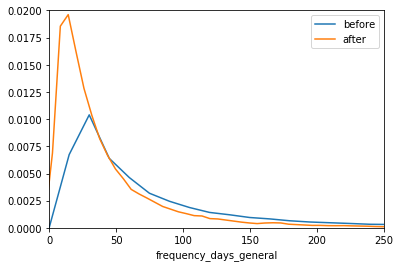

In [30]:
plt.xlim(0, 250)
plt.ylim(0, 0.02)
sns.distplot(before.groupby(['encrypted_customer_id'])['frequency_days_general'].mean().reset_index()['frequency_days_general'],
            hist = False, label = 'before')
sns.distplot(after.groupby(['encrypted_customer_id'])['frequency_days_general'].mean().reset_index()['frequency_days_general'],
            hist = False, label = 'after')
plt.show()

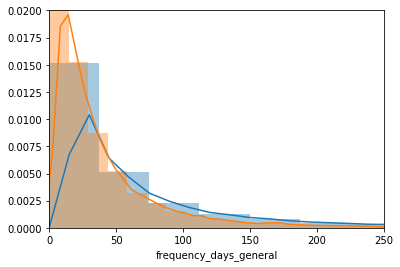

In [31]:
plt.xlim(0, 250)
plt.ylim(0, 0.02)
sns.distplot(before.groupby(['encrypted_customer_id'])['frequency_days_general'].mean().reset_index()['frequency_days_general'],
            hist = True, label = 'before')
sns.distplot(after.groupby(['encrypted_customer_id'])['frequency_days_general'].mean().reset_index()['frequency_days_general'],
            hist = True, label = 'after')
plt.show()

## Change in frequency of purchasing by Bucket Before and After PMD

In [32]:
def attach_labels(source_df, destination_df):
    
    #from before
    
    labels = source_df[['encrypted_customer_id','label']]
    labels = labels.drop_duplicates()
    output = pd.merge(left = destination_df, right = labels,
                        left_on=['encrypted_customer_id'], right_on = ['encrypted_customer_id'], how = 'left')
    
    return output

In [33]:
after_labels = attach_labels(before, after)
after_labels.shape

(193802, 19)

In [34]:
# before.groupby(['encrypted_customer_id',
# 'label'])['frequency_days_general'].mean().reset_index().groupby("label")['frequency_days_general'].mean().reset_index()

In [35]:
# after_labels.groupby(['encrypted_customer_id',
# 'label'])['frequency_days_general'].mean().reset_index().groupby("label")['frequency_days_general'].mean().reset_index()

In [36]:
#Separate into percentiles
before.groupby("encrypted_customer_id")['units_ever'].mean().reset_index()['units_ever'].quantile([0.25,0.50,0.75])

0.25     3.0
0.50     8.0
0.75    22.0
Name: units_ever, dtype: float64

### Change in shares of promo / non promo purchases by Bucket by Promo

In [85]:
def get_share(df):
    
    """look into the share of transactions which are promotional"""
    
    a = df.groupby(['label','is_promo','is_pmd'])['units_byPromo'].sum().reset_index()
    b = pd.merge(left = a,right = a.groupby(['label'])['units_byPromo'].sum().reset_index(),
            left_on = ['label'], right_on = ['label'], how = 'left')
    b['share'] = b['units_byPromo_x'] / b['units_byPromo_y']
    return b

In [86]:
b = get_share(before)
b

,label,is_promo,is_pmd,units_byPromo_x,units_byPromo_y,share
0,A_Below_25,non_promo,non_pmd,22086,25437,0.868263
1,A_Below_25,promo,non_pmd,3351,25437,0.131737
2,B_Between_25_50,non_promo,non_pmd,88223,100108,0.881278
3,B_Between_25_50,promo,non_pmd,11885,100108,0.118722
4,C_Between_50_75,non_promo,non_pmd,257912,285494,0.903389
5,C_Between_50_75,promo,non_pmd,27582,285494,0.096611
6,D_Above_75,non_promo,non_pmd,1275571,1350842,0.944278
7,D_Above_75,promo,non_pmd,75271,1350842,0.055722


In [87]:
a = get_share(after_labels)
a

,label,is_promo,is_pmd,units_byPromo_x,units_byPromo_y,share
0,A_Below_25,non_promo,non_pmd,76910,129977,0.591720
1,A_Below_25,promo,is_pmd,37212,129977,0.286297
2,A_Below_25,promo,non_pmd,15855,129977,0.121983
3,B_Between_25_50,non_promo,non_pmd,139047,218286,0.636995
4,B_Between_25_50,promo,is_pmd,50288,218286,0.230377
5,B_Between_25_50,promo,non_pmd,28951,218286,0.132629
6,C_Between_50_75,non_promo,non_pmd,233639,341239,0.684678
7,C_Between_50_75,promo,is_pmd,61220,341239,0.179405
8,C_Between_50_75,promo,non_pmd,46380,341239,0.135916
9,D_Above_75,non_promo,non_pmd,580946,767184,0.757245


### Change in frequency of purchasing by Bucket Before and After PMD by Promo - FYI

In [40]:
#before.groupby(['is_promo','is_pmd','label'])['frequency_days_byPromo'].mean().reset_index()

In [41]:
#after_labels.groupby(['is_promo','is_pmd','label'])['frequency_days_byPromo'].mean().reset_index()

### Change in total ARPU by Bucket Before and After PMD by Promo

In [42]:
def get_subset_for_ARPU(df):
    

    get_that = df[['encrypted_customer_id','label','revenue_ever','units_ever','timeframe_general',
                  'revenue_byPromo','units_byPromo','timeframe_general_by_Promo','is_promo','is_pmd']]
    get_that['corrected_timeframe_general'] = np.where(get_that['timeframe_general'] == 0.0, 1.0, get_that['timeframe_general'])
    get_that['corrected_timeframe_byPromo'] = np.where(get_that['timeframe_general_by_Promo'] == 0.0, 1.0, get_that['timeframe_general_by_Promo'])
    
    get_that = get_that.drop_duplicates()
    get_that['ARPU_monthly'] = get_that['revenue_ever'] / get_that['corrected_timeframe_general']
    get_that['units_monthly'] = get_that['units_ever'] / get_that['corrected_timeframe_general']
    get_that['ASP'] = get_that['revenue_ever'] / get_that['units_ever']
    
    
    get_that['ARPU_monthlyByPromo'] = get_that['revenue_byPromo'] / get_that['corrected_timeframe_byPromo']
    get_that['units_monthlyByPromo'] = get_that['units_byPromo'] / get_that['corrected_timeframe_byPromo']
    get_that['ASPByPromo'] = get_that['revenue_byPromo'] / get_that['units_byPromo']
    
    

    return get_that

In [43]:
s_before = get_subset_for_ARPU(before)
s_after = get_subset_for_ARPU(after_labels)

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [44]:
s_before.head()

,encrypted_customer_id,label,revenue_ever,units_ever,timeframe_general,revenue_byPromo,units_byPromo,timeframe_general_by_Promo,is_promo,is_pmd,corrected_timeframe_general,corrected_timeframe_byPromo,ARPU_monthly,units_monthly,ASP,ARPU_monthlyByPromo,units_monthlyByPromo,ASPByPromo
0,A00055623TIUZLH2ZWTA4,C_Between_50_75,54.87,14,5.453911,40.73,11,5.453911,non_promo,non_pmd,5.453911,5.453911,10.060671,2.566965,3.919286,7.468036,2.016901,3.702727
1,A00055623TIUZLH2ZWTA4,C_Between_50_75,54.87,14,5.453911,14.14,3,3.548327,promo,non_pmd,5.453911,3.548327,10.060671,2.566965,3.919286,3.984976,0.845469,4.713333
2,A0010178Z9I36ZAB04EL,C_Between_50_75,49.92,15,4.599684,17.46,6,3.449763,non_promo,non_pmd,4.599684,3.449763,10.852920,3.261094,3.328000,5.061218,1.739250,2.910000
3,A0010178Z9I36ZAB04EL,C_Between_50_75,49.92,15,4.599684,32.46,9,4.599684,promo,non_pmd,4.599684,4.599684,10.852920,3.261094,3.328000,7.057007,1.956656,3.606667
4,A0014522W2ONKFKKTTPL,B_Between_25_50,14.55,4,0.854227,7.07,2,0.065710,non_promo,non_pmd,0.854227,0.065710,17.032944,4.682596,3.637500,107.594353,30.436875,3.535000


## Story about ARPU, ASP, units, top down approach

### Total ARPU per month

In [45]:
s_before.groupby(['encrypted_customer_id','label','is_promo',
'is_pmd'])['ARPU_monthly'].mean().reset_index().groupby("label")['ARPU_monthly'].mean().reset_index()

,label,ARPU_monthly
0,A_Below_25,12.650896
1,B_Between_25_50,8.830637
2,C_Between_50_75,6.288074
3,D_Above_75,11.472020


In [46]:
s_after.groupby(['encrypted_customer_id','label','is_promo',
'is_pmd'])['ARPU_monthly'].mean().reset_index().groupby("label")['ARPU_monthly'].mean().reset_index()

,label,ARPU_monthly
0,A_Below_25,7.703961
1,B_Between_25_50,7.779178
2,C_Between_50_75,8.748288
3,D_Above_75,13.916456


In [47]:
print("BEFORE: " , s_before.groupby(['encrypted_customer_id'])['ARPU_monthly'].mean().reset_index()['ARPU_monthly'].mean() )
print("AFTER: "  , s_after.groupby(['encrypted_customer_id'])['ARPU_monthly'].mean().reset_index()['ARPU_monthly'].mean()  )

BEFORE:  9.410695676509244
AFTER:  9.38023495965008


#### Net Change in ARPU 

In [48]:
now = s_after.groupby(['encrypted_customer_id'])['ARPU_monthly'].mean().reset_index()['ARPU_monthly'].mean()
past = s_before.groupby(['encrypted_customer_id'])['ARPU_monthly'].mean().reset_index()['ARPU_monthly'].mean()
print("Net change in ARPU monthly: " , now / past )

Net change in ARPU monthly:  0.9967631811816847


### Total units per month 

In [49]:
s_before.groupby(['encrypted_customer_id',
'label'])['units_monthly'].mean().reset_index().groupby(['label'])['units_monthly'].mean().reset_index()

,label,units_monthly
0,A_Below_25,2.920910
1,B_Between_25_50,2.272579
2,C_Between_50_75,1.450611
3,D_Above_75,2.487224


In [50]:
s_after.groupby(['encrypted_customer_id',
'label'])['units_monthly'].mean().reset_index().groupby(['label'])['units_monthly'].mean().reset_index()

,label,units_monthly
0,A_Below_25,2.347713
1,B_Between_25_50,2.231746
2,C_Between_50_75,2.339336
3,D_Above_75,3.207331


In [51]:
print("BEFORE UNITS: " , 
s_before.groupby(['encrypted_customer_id'])['units_monthly'].mean().reset_index()['units_monthly'].mean())
print("AFTER UNITS: " , 
s_after.groupby(['encrypted_customer_id'])['units_monthly'].mean().reset_index()['units_monthly'].mean())

BEFORE UNITS:  2.249140711397561
AFTER UNITS:  2.535019847321766


### Total ASP

In [52]:
s_before.groupby(['encrypted_customer_id',
'label'])['ASP'].mean().reset_index().groupby("label")['ASP'].mean().reset_index()

,label,ASP
0,A_Below_25,4.190352
1,B_Between_25_50,4.260544
2,C_Between_50_75,4.411046
3,D_Above_75,4.501557


In [53]:
s_after.groupby(['encrypted_customer_id',
'label'])['ASP'].mean().reset_index().groupby("label")['ASP'].mean().reset_index()

,label,ASP
0,A_Below_25,3.048202
1,B_Between_25_50,3.346397
2,C_Between_50_75,3.717961
3,D_Above_75,4.238220


In [54]:
print("BEFORE ASP: " , 
s_before.groupby(['encrypted_customer_id'])['ASP'].mean().reset_index()['ASP'].mean())
print("AFTER ASP: " ,
s_after.groupby(['encrypted_customer_id'])['ASP'].mean().reset_index()['ASP'].mean())

BEFORE ASP:  4.347040009390694
AFTER ASP:  3.6088282608006264


### All by Promo

In [55]:
s_before.groupby(['encrypted_customer_id','label','is_promo',
'is_pmd'])['ARPU_monthlyByPromo'].mean().reset_index().groupby(['label','is_promo',
'is_pmd'])['ARPU_monthlyByPromo'].mean().reset_index()

,label,is_promo,is_pmd,ARPU_monthlyByPromo
0,A_Below_25,non_promo,non_pmd,10.870906
1,A_Below_25,promo,non_pmd,7.142722
2,B_Between_25_50,non_promo,non_pmd,9.861704
3,B_Between_25_50,promo,non_pmd,10.912288
4,C_Between_50_75,non_promo,non_pmd,6.030471
5,C_Between_50_75,promo,non_pmd,10.517518
6,D_Above_75,non_promo,non_pmd,10.485244
7,D_Above_75,promo,non_pmd,8.941023


In [56]:
s_after.groupby(['encrypted_customer_id','label','is_promo',
'is_pmd'])['ARPU_monthlyByPromo'].mean().reset_index().groupby(['label','is_promo',
'is_pmd'])['ARPU_monthlyByPromo'].mean().reset_index()

,label,is_promo,is_pmd,ARPU_monthlyByPromo
0,A_Below_25,non_promo,non_pmd,9.397089
1,A_Below_25,promo,is_pmd,4.130626
2,A_Below_25,promo,non_pmd,8.666305
3,B_Between_25_50,non_promo,non_pmd,9.490412
4,B_Between_25_50,promo,is_pmd,4.100910
5,B_Between_25_50,promo,non_pmd,7.561779
6,C_Between_50_75,non_promo,non_pmd,9.617044
7,C_Between_50_75,promo,is_pmd,3.954489
8,C_Between_50_75,promo,non_pmd,7.477974
9,D_Above_75,non_promo,non_pmd,13.091815


In [57]:
s_before.groupby(['encrypted_customer_id','label','is_promo',
'is_pmd'])['units_monthlyByPromo'].mean().reset_index().groupby(['label','is_promo',
'is_pmd'])['units_monthlyByPromo'].mean().reset_index()

,label,is_promo,is_pmd,units_monthlyByPromo
0,A_Below_25,non_promo,non_pmd,2.587437
1,A_Below_25,promo,non_pmd,1.901998
2,B_Between_25_50,non_promo,non_pmd,2.450332
3,B_Between_25_50,promo,non_pmd,2.756195
4,C_Between_50_75,non_promo,non_pmd,1.410036
5,C_Between_50_75,promo,non_pmd,2.551425
6,D_Above_75,non_promo,non_pmd,2.402347
7,D_Above_75,promo,non_pmd,2.104275


In [58]:
s_after.groupby(['encrypted_customer_id','label','is_promo',
'is_pmd'])['units_monthlyByPromo'].mean().reset_index().groupby(['label','is_promo',
'is_pmd'])['units_monthlyByPromo'].mean().reset_index()

,label,is_promo,is_pmd,units_monthlyByPromo
0,A_Below_25,non_promo,non_pmd,2.232454
1,A_Below_25,promo,is_pmd,2.055408
2,A_Below_25,promo,non_pmd,2.180039
3,B_Between_25_50,non_promo,non_pmd,2.160836
4,B_Between_25_50,promo,is_pmd,1.988764
5,B_Between_25_50,promo,non_pmd,1.978018
6,C_Between_50_75,non_promo,non_pmd,2.156580
7,C_Between_50_75,promo,is_pmd,1.826229
8,C_Between_50_75,promo,non_pmd,1.901876
9,D_Above_75,non_promo,non_pmd,2.707663


In [59]:
s_before.groupby(['encrypted_customer_id','label','is_promo',
'is_pmd'])['ASPByPromo'].mean().reset_index().groupby(['label','is_promo',
'is_pmd'])['ASPByPromo'].mean().reset_index()

,label,is_promo,is_pmd,ASPByPromo
0,A_Below_25,non_promo,non_pmd,4.258739
1,A_Below_25,promo,non_pmd,3.818014
2,B_Between_25_50,non_promo,non_pmd,4.331943
3,B_Between_25_50,promo,non_pmd,4.010998
4,C_Between_50_75,non_promo,non_pmd,4.476005
5,C_Between_50_75,promo,non_pmd,4.196019
6,D_Above_75,non_promo,non_pmd,4.541081
7,D_Above_75,promo,non_pmd,4.422258


In [60]:
s_after.groupby(['encrypted_customer_id','label','is_promo',
'is_pmd'])['ASPByPromo'].mean().reset_index().groupby(['label','is_promo',
'is_pmd'])['ASPByPromo'].mean().reset_index()

,label,is_promo,is_pmd,ASPByPromo
0,A_Below_25,non_promo,non_pmd,4.352695
1,A_Below_25,promo,is_pmd,2.016276
2,A_Below_25,promo,non_pmd,3.814095
3,B_Between_25_50,non_promo,non_pmd,4.451296
4,B_Between_25_50,promo,is_pmd,2.059929
5,B_Between_25_50,promo,non_pmd,3.857985
6,C_Between_50_75,non_promo,non_pmd,4.640152
7,C_Between_50_75,promo,is_pmd,2.129090
8,C_Between_50_75,promo,non_pmd,3.998729
9,D_Above_75,non_promo,non_pmd,4.955146


### Visiualize

### Change in distribution by Bucket Before and After PMD by Promo

In [61]:
# Subset only those who made PMD

pmd_subset = df_new[df_new['is_pmd'] == 'is_pmd']
pmd_subset['month_year'] = pmd_subset['fufill_date_local'].dt.to_period('M')

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [62]:
pmd_subset.groupby(['month_year','encrypted_customer_id'])['units'].sum().reset_index().head()

,month_year,encrypted_customer_id,units
0,2017-07,A004411433I164JUINEOQ,1
1,2017-07,A00474663E933MVP1SL57,1
2,2017-07,A00539452VSNAVPQNQVPI,1
3,2017-07,A00635463QF582P5R45VO,1
4,2017-07,A0232463SLDOY4V2SYG,2


### Distribution by month

In [63]:
def prepare_dist(df):
    
    dist = df.groupby(['month_year','units'])['encrypted_customer_id'].nunique().reset_index()
    dist['month_year_date'] = dist['month_year'].apply(lambda x : x.to_timestamp())
    total = dist.groupby("month_year_date")['encrypted_customer_id'].sum().reset_index()
    dist = pd.merge(left=dist,right=total,left_on=['month_year_date'], right_on=['month_year_date'], how = 'left')
    dist['share'] = dist['encrypted_customer_id_x'] / dist['encrypted_customer_id_y']
    
    
    dist['buckets'] = np.select(
        [
                    dist['units'] == 1,
        
                    dist['units'] == 2,
                     
                    (dist['units'] >=  3 ) &
                    (dist['units'] <=  5 ),
                    
                   dist['units'] > 5 
        ],
        [
            'A_one',
            'B_two',
            'C_three_to_five',
            'D_above_five'
        ],
        default = 'E_Unknown')
        
    return dist

In [64]:
dist = prepare_dist(pmd_subset)

In [65]:
to_pivot_this = dist.groupby(['month_year','buckets'])['share'].sum().reset_index()
to_pivot_this.head()

,month_year,buckets,share
0,2017-07,A_one,0.909657
1,2017-07,B_two,0.070280
2,2017-07,C_three_to_five,0.019083
3,2017-07,D_above_five,0.000980
4,2017-08,A_one,0.933221


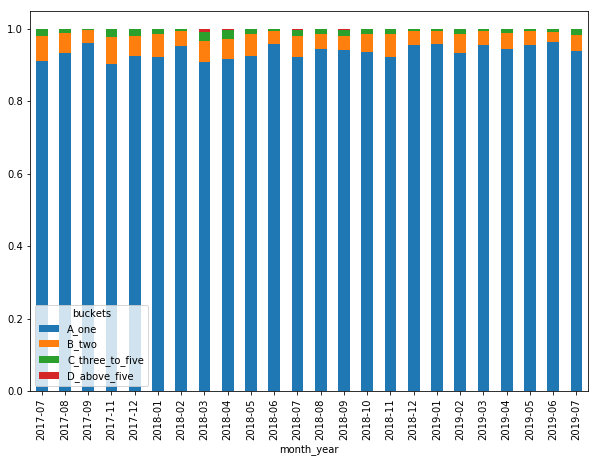

In [66]:
pivot_df = to_pivot_this.pivot(index='month_year', columns='buckets', values='share')
pivot_df.plot.bar(stacked=True, figsize=(10,7))

In [67]:
#pivot_df.to_csv("DE_dist.csv")

### Build Cohorts

In [68]:
def prepare_to_next(df):
    dist = df.groupby(['month_year','encrypted_customer_id'])['units'].sum().reset_index()
    dist['month_year_date'] = dist['month_year'].apply(lambda x : x.to_timestamp())
    return dist

In [69]:
d = prepare_to_next(pmd_subset)
d.head()

,month_year,encrypted_customer_id,units,month_year_date
0,2017-07,A004411433I164JUINEOQ,1,2017-07-01
1,2017-07,A00474663E933MVP1SL57,1,2017-07-01
2,2017-07,A00539452VSNAVPQNQVPI,1,2017-07-01
3,2017-07,A00635463QF582P5R45VO,1,2017-07-01
4,2017-07,A0232463SLDOY4V2SYG,2,2017-07-01


#### Create a period column based on the OrderDate 

In [70]:
pmd_subset['month_year_proper'] = pmd_subset['fufill_date_local'].apply(lambda x: x.strftime("%Y-%m"))

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


#### Determine the user's cohort group (based on their first order)

In [71]:
pmd_subset.set_index('encrypted_customer_id', inplace=True)

pmd_subset['CohortGroup'] = pmd_subset.groupby(level=0)['fufill_date_local'].min().apply(lambda x: x.strftime('%Y-%m'))
pmd_subset.reset_index(inplace=True)
pmd_subset.head()

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,encrypted_customer_id,is_promo,is_pmd,fufill_date_local,revenue,units,min_date,max_date,first_pmd_date,first_ever_purchase_date,month_year,month_year_proper,CohortGroup
0,A1E4UD2ON5HELH,promo,is_pmd,2019-03-02,1.66,1,2019-03-02,2019-03-02,2019-02-22,2018-08-19,2019-03,2019-03,2019-02
1,A3BUEBDDPVNJEH,promo,is_pmd,2017-07-29,1.66,1,2017-07-29,2017-07-29,2017-07-29,2017-07-29,2017-07,2017-07,2017-07
2,A3OEE7Z5IE6T32,promo,is_pmd,2019-04-12,1.66,1,2019-04-12,2019-04-12,2017-07-09,2017-01-14,2019-04,2019-04,2017-07
3,A23E5QU53W5B3E,promo,is_pmd,2017-08-07,1.66,1,2017-08-07,2017-08-07,2017-08-07,2015-04-19,2017-08,2017-08,2017-08
4,A7DHTY3B1CD30,promo,is_pmd,2018-05-28,1.66,1,2018-05-28,2018-05-28,2018-05-28,2015-11-11,2018-05,2018-05,2018-05


#### Rollup data by CohortGroup & OrderPeriod

In [72]:
grouped = pmd_subset.groupby(['CohortGroup', 'month_year_proper'])

# count the unique users, orders, and total revenue per Group + Period
cohorts = grouped.agg({'encrypted_customer_id': pd.Series.nunique,
                       'units': np.sum,
                       'revenue': np.sum})

# make the column names more meaningful
cohorts.rename(columns={'UserId': 'encrypted_customer_id',
                        'OrderId': 'units'}, inplace=True)
cohorts.head()

encrypted_customer_id  units   revenue
CohortGroup month_year_proper                                        
2017-07     2017-07                            16605  24972  41485.16
            2017-08                             6149  10171  16901.64
            2017-09                             1712   1981   3291.43
            2017-11                             1466   2060   3422.90
            2017-12                             2200   2928   4863.12

#### Label the CohortPeriod for each CohortGroup

In [73]:
def cohort_period(df):
    """
    Creates a `CohortPeriod` column, which is the Nth period based on the user's first purchase.
    
    Example
    -------
    Say you want to get the 3rd month for every user:
        df.sort(['UserId', 'OrderTime', inplace=True)
        df = df.groupby('UserId').apply(cohort_period)
        df[df.CohortPeriod == 3]
    """
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

encrypted_customer_id  units   revenue  \
CohortGroup month_year_proper                                           
2017-07     2017-07                            16605  24972  41485.16   
            2017-08                             6149  10171  16901.64   
            2017-09                             1712   1981   3291.43   
            2017-11                             1466   2060   3422.90   
            2017-12                             2200   2928   4863.12   

                               CohortPeriod  
CohortGroup month_year_proper                
2017-07     2017-07                       1  
            2017-08                       2  
            2017-09                       3  
            2017-11                       4  
            2017-12                       5

#### User Retention by Cohort Group

In [74]:
# reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['encrypted_customer_id'].groupby(level=0).first()

In [75]:
user_retention = cohorts['encrypted_customer_id'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head()

CohortGroup,2017-07,2017-08,2017-09,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,...,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07
CohortPeriod,,,,,,,,,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2,0.370310,0.090736,0.051546,0.162909,0.093249,0.166723,0.029251,0.133729,0.062016,0.026844,...,0.060411,0.076190,0.084942,0.095005,0.117991,0.106418,0.088551,0.074532,0.093161,NaN
3,0.103101,0.052121,0.086186,0.100902,0.114441,0.020291,0.057848,0.050066,0.013417,0.154846,...,0.056113,0.075000,0.076062,0.072478,0.116759,0.081144,0.056646,0.072057,NaN,NaN
4,0.088287,0.084935,0.060206,0.121195,0.019982,0.060534,0.082296,0.011858,0.138939,0.079966,...,0.069723,0.071429,0.061776,0.104146,0.103820,0.054207,0.055793,NaN,NaN,NaN
5,0.132490,0.074057,0.098969,0.019729,0.052377,0.100778,0.018118,0.160738,0.068277,0.005934,...,0.073543,0.061111,0.102703,0.097290,0.063463,0.055870,NaN,NaN,NaN,NaN


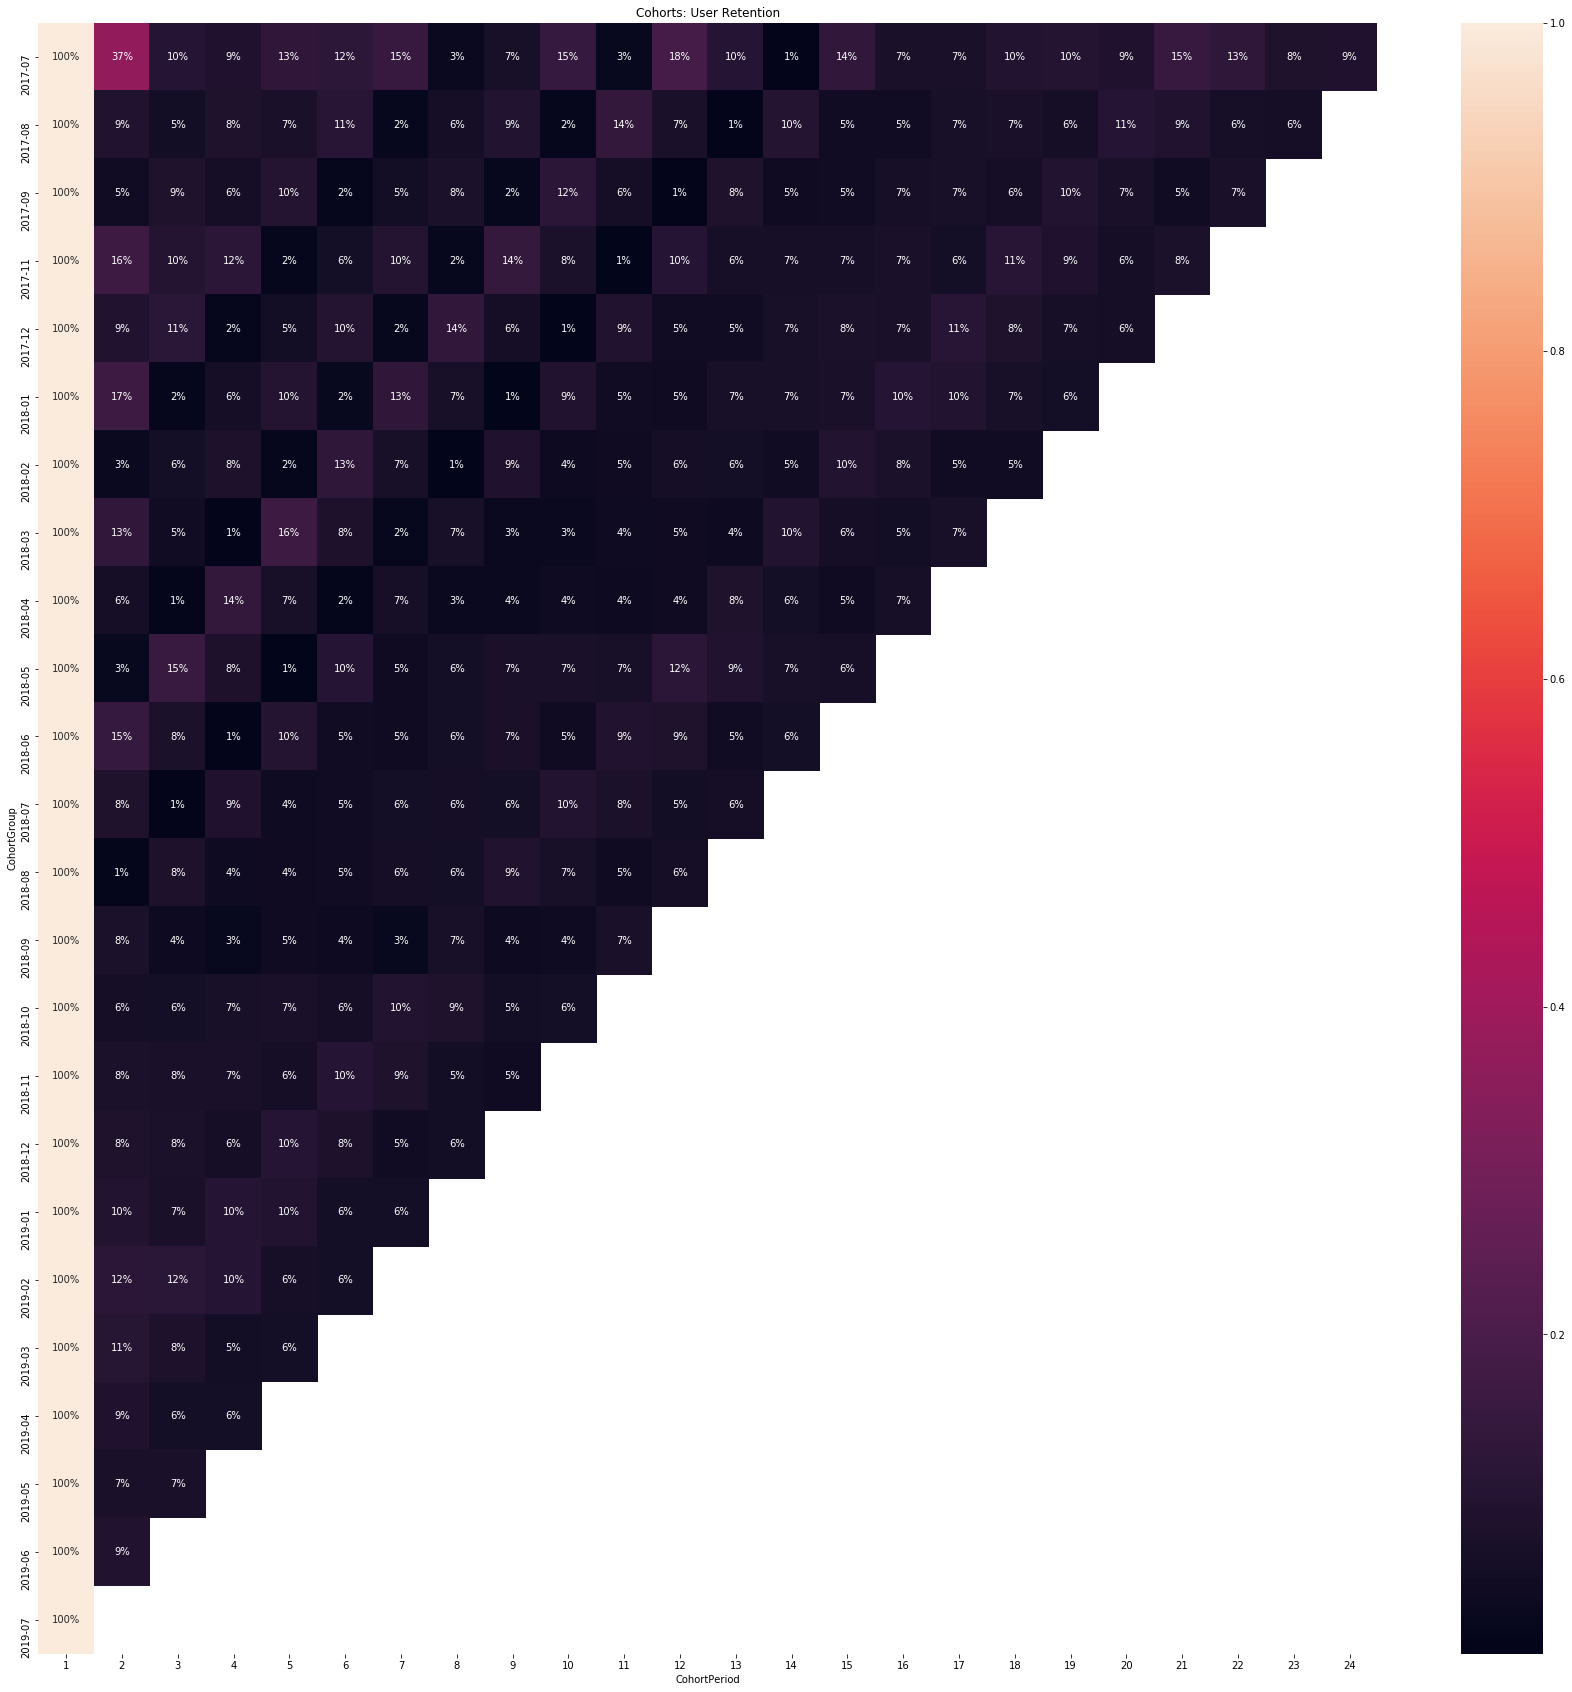

In [76]:
plt.figure(figsize=(30, 30))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

### How many returning vs new PMD users

In [77]:
pmd_subset['is_first_PMD'] = np.where(pmd_subset['fufill_date_local'] == pmd_subset['first_pmd_date'], 'Y','N')

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [78]:
pmd_subset.head()

,encrypted_customer_id,is_promo,is_pmd,fufill_date_local,revenue,units,min_date,max_date,first_pmd_date,first_ever_purchase_date,month_year,month_year_proper,CohortGroup,is_first_PMD
0,A1E4UD2ON5HELH,promo,is_pmd,2019-03-02,1.66,1,2019-03-02,2019-03-02,2019-02-22,2018-08-19,2019-03,2019-03,2019-02,N
1,A3BUEBDDPVNJEH,promo,is_pmd,2017-07-29,1.66,1,2017-07-29,2017-07-29,2017-07-29,2017-07-29,2017-07,2017-07,2017-07,Y
2,A3OEE7Z5IE6T32,promo,is_pmd,2019-04-12,1.66,1,2019-04-12,2019-04-12,2017-07-09,2017-01-14,2019-04,2019-04,2017-07,N
3,A23E5QU53W5B3E,promo,is_pmd,2017-08-07,1.66,1,2017-08-07,2017-08-07,2017-08-07,2015-04-19,2017-08,2017-08,2017-08,Y
4,A7DHTY3B1CD30,promo,is_pmd,2018-05-28,1.66,1,2018-05-28,2018-05-28,2018-05-28,2015-11-11,2018-05,2018-05,2018-05,Y


In [79]:
def dedup(df):
    c = df[['encrypted_customer_id','month_year_proper','is_first_PMD']].sort_values(by = 'is_first_PMD', ascending = False)
    new = c[c['is_first_PMD'] == 'Y']
    new['flag'] = 1
    
    b = pd.merge(left=c,right=new,left_on=['encrypted_customer_id','month_year_proper'],
        right_on=['encrypted_customer_id','month_year_proper'],how='left')
    d = b[~ ((b['is_first_PMD_x'] == 'N') & (b['flag'] == 1.0))]
    
    out = d[['encrypted_customer_id','month_year_proper','is_first_PMD_x']]
    out.columns = ['encrypted_customer_id','month_year_proper','is_first_PMD']
    return out

In [80]:
out = dedup(pmd_subset)

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [81]:
r = out.groupby(['month_year_proper','is_first_PMD'])['encrypted_customer_id'].nunique().reset_index()
d = out.groupby(['month_year_proper'])['encrypted_customer_id'].nunique().reset_index()
rd = pd.merge(left=r,right=d,left_on='month_year_proper',right_on='month_year_proper',how = 'left')
rd['share'] = rd['encrypted_customer_id_x'] / rd['encrypted_customer_id_y']
rd.tail(10)

,month_year_proper,is_first_PMD,encrypted_customer_id_x,encrypted_customer_id_y,share
37,2019-03,N,5432,8439,0.643678
38,2019-03,Y,3007,8439,0.356322
39,2019-04,N,9237,15098,0.611803
40,2019-04,Y,5861,15098,0.388197
41,2019-05,N,8099,11735,0.690158
42,2019-05,Y,3636,11735,0.309842
43,2019-06,N,5768,8473,0.680751
44,2019-06,Y,2705,8473,0.319249
45,2019-07,N,6304,9883,0.637863
46,2019-07,Y,3579,9883,0.362137


In [82]:
#rd.to_csv("DE_by_returning.csv")